# Decision Trees

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

Why are we learning about decision trees?

- Can be applied to both regression and classification problems
- Many useful properties
- Very popular
- Basis for more sophisticated models
- Have a different way of "thinking" than the other models we have studied

## Lesson objectives

Students will be able to:

- Explain how a decision tree is created
- Build a decision tree model in scikit-learn
- Tune a decision tree model and explain how tuning impacts the model
- Interpret a tree diagram
- Describe the key differences between regression and classification trees
- Decide whether a decision tree is an appropriate model for a given problem

# Part 1: Regression trees

Major League Baseball player data from 1986-87:

- **Years** (x-axis): number of years playing in the major leagues
- **Hits** (y-axis): number of hits in the previous year
- **Salary** (color): low salary is blue/green, high salary is red/yellow

![Salary data](images/salary_color.png)

Group exercise:

- The data above is our **training data**.
- We want to build a model that predicts the Salary of **future players** based on Years and Hits.
- We are going to "segment" the feature space into regions, and then use the **mean Salary in each region** as the predicted Salary for future players.
- Intuitively, you want to **maximize** the similarity (or "homogeneity") within a given region, and **minimize** the similarity between different regions.

Rules for segmenting:

- You can only use **straight lines**, drawn one at a time.
- Your line must either be **vertical or horizontal**.
- Your line **stops** when it hits an existing line.

![Salary regions](images/salary_regions.png)

Above are the regions created by a computer:

- $R_1$: players with **less than 5 years** of experience, mean Salary of **\$166,000 **
- $R_2$: players with **5 or more years** of experience and **less than 118 hits**, mean Salary of **\$403,000 **
- $R_3$: players with **5 or more years** of experience and **118 hits or more**, mean Salary of **\$846,000 **

**Note:** Years and Hits are both integers, but the convention is to use the **midpoint** between adjacent values to label a split.

These regions are used to make predictions on **out-of-sample data**. Thus, there are only three possible predictions! (Is this different from how **linear regression** makes predictions?)

Below is the equivalent regression tree:

![Salary tree](images/salary_tree.png)

The first split is **Years < 4.5**, thus that split goes at the top of the tree. When a splitting rule is **True**, you follow the left branch. When a splitting rule is **False**, you follow the right branch.

For players in the **left branch**, the mean Salary is \$166,000, thus you label it with that value. (Salary has been divided by 1000 and log-transformed to 5.11.)

For players in the **right branch**, there is a further split on **Hits < 117.5**, dividing players into two more Salary regions: \$403,000 (transformed to 6.00), and \$846,000 (transformed to 6.74).

![Salary tree annotated](images/salary_tree_annotated.png)

**What does this tree tell you about your data?**

- Years is the most important factor determining Salary, with a lower number of Years corresponding to a lower Salary.
- For a player with a lower number of Years, Hits is not an important factor determining Salary.
- For a player with a higher number of Years, Hits is an important factor determining Salary, with a greater number of Hits corresponding to a higher Salary.

**Question:** What do you like and dislike about decision trees so far?

## How does a computer build a regression tree?

**Ideal approach:** Consider every possible partition of the feature space (computationally infeasible)

**"Good enough" approach:** recursive binary splitting

1. Begin at the top of the tree.
2. For **every feature**, examine **every possible cutpoint**, and choose the feature and cutpoint such that the resulting tree has the lowest possible mean squared error (MSE). Make that split.
3. Examine the two resulting regions, and again make a **single split** (in one of the regions) to minimize the MSE.
4. Keep repeating step 3 until a **stopping criterion** is met:
    - maximum tree depth (maximum number of splits required to arrive at a leaf)
    - minimum number of observations in a leaf

## What happens when we grow a tree too deep?

- Left: Regression tree for Salary **grown deeper**
- Right: Comparison of the **training, testing, and cross-validation errors** for trees with different numbers of leaves

![Salary tree grown deep](images/salary_tree_deep.png)

The **training error** continues to go down as the tree size increases (due to overfitting), but the lowest **cross-validation error** occurs for a tree with 3 leaves.

# Part 2: Classification trees

**Example:** Predict whether Barack Obama or Hillary Clinton will win the Democratic primary in a particular county in 2008:

![Obama-Clinton decision tree](images/obama_clinton_tree.jpg)

**Questions:**

- What are the observations? How many observations are there?
- What is the response variable?
- What are the features?
- What is the most predictive feature?
- Why does the tree split on high school graduation rate twice in a row?
- What is the class prediction for the following county: 15% African-American, 90% high school graduation rate, located in the South, high poverty, high population density?
- What is the predicted probability for that same county?

## Comparing regression trees and classification trees

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize Gini index (discussed below)|

### Comparing classification error rate and Gini index

- Gini index is generally preferred because it will make splits that **increase node purity**, even if that split does not change the classification error rate.
- Node purity is important because we're interested in the **class proportions** in each region, since that's how we calculate the **predicted probability** of each class.
- scikit-learn's default splitting criteria for classification trees is Gini index.

Note: There is another common splitting criteria called **cross-entropy**. It's numerically similar to Gini index, but slower to compute, thus it's not as popular as Gini index.

## Building a classification tree in scikit-learn

We'll build a classification tree using the Titanic data:

In [2]:
# inspired from http://www.mariofrank.net/touchalytics/index.html
import pandas as pd
touch = pd.read_csv('data/touch.csv')
touch.head()

,Unnamed: 0,user_id,doc_id,inter_stroke_time,stroke_duration,start_x,start_y,stop_x,stop_y,direct_end_to_end,...,length_of_trajectory,length_of_trajectory.1,ratio_end_to_end,average_velocity,median_acceleration,mid_stroke_pressure,mid_stroke_area,mid_stroke_finger,change_finger,phone_orientation
0,0,37,4,0.341,0.256,27.416,-27.113,12.3980,-32.960,16.1160,...,-2.581200,16.1320,0.99898,63.018,-432.24,0.32,0.044444,0.0,0,1
1,1,37,4,0.913,0.086,21.771,-30.037,9.8778,-33.867,12.4950,...,-2.199400,12.5960,0.99197,146.470,5117.70,0.60,0.088889,0.0,0,1
2,2,37,4,0.733,0.111,10.886,-34.169,26.9120,-34.673,16.0340,...,0.086288,16.2030,0.98959,145.970,-3563.50,0.48,0.044444,0.0,0,1
3,3,37,4,0.448,0.094,19.151,-34.572,12.7000,-36.790,6.8213,...,-2.723100,6.9674,0.97902,74.122,-4604.10,0.40,0.044444,0.0,0,1
4,4,37,4,0.519,0.056,27.718,-32.758,14.6150,-37.294,13.8660,...,-2.717000,13.8710,0.99965,247.690,-21377.00,0.44,0.044444,0.0,0,1


* Attribute 1	:	user id (used for labelling, not for. training)
* Attribute 2	:	doc id (used for labelling, not for. training)
* Attribute 3	:	inter-stroke time
* Attribute 4	:	stroke duration
* Attribute 5	:	start $x$
* Attribute 6  	:	start $y$
* Attribute 7  	:	stop $x$
* Attribute 8  	:	stop $y$
* Attribute 9  	:	direct end-to-end distance
* Attribute 10  	:	mean resultant length
* Attribute 11  	:	up/down/left/right flag
* Attribute 12  	:	direction of end-to-end line
* Attribute 13  	:	phone id (used for labelling, not for. training)
* Attribute 14  	:	20\%-perc. pairwise velocity
* Attribute 15  	:	50\%-perc. pairwise velocity
* Attribute 16  	:	80\%-perc. pairwise velocity
* Attribute 17  	:	20\%-perc. pairwise acc
* Attribute 18  	:	50\%-perc. pairwise acc
* Attribute 19  	:	80\%-perc. pairwise acc
* Attribute 20 	:	median velocity at last 3 pts
* Attribute 21  	:	largest deviation from end-to-end line
* Attribute 22  	:	20\%-perc. dev. from end-to-end line
* Attribute 23  	:	50\%-perc. dev. from end-to-end line
* Attribute 24  	:	80\%-perc. dev. from end-to-end line
* Attribute 25  	:	average direction
* Attribute 26  	:	length of trajectory
* Attribute 27  	:	ratio end-to-end dist and length of trajectory
* Attribute 28	:	average velocity
* Attribute 29	:	median acceleration at first 5 points
* Attribute 30	:	mid-stroke pressure
* Attribute 31	:	mid-stroke area covered
* Attribute 32	:	mid-stroke finger orientation
* Attribute 33	:	change of finger orientation
* Attribute 34	:	phone orientation

In [3]:
# define X and y
feature_cols = ['inter_stroke_time', 'stroke_duration', 'start_x', 'start_y', 'stop_x', 'stop_y', 
                'direct_end_to_end', 'mean_resultant', 'udlr_flag', 'direction_end_to_end_line', 
                'twenty_v', 'fifty_v', 'eighty_v', 'twenty_a', 
                'fifty_a', 'eighty_a', 'largest_deviation', 'twenty_d', 'fifty_d', 'eighty_d',
                'average_direction', 'length_of_trajectory', 'length_of_trajectory',
                'ratio_end_to_end', 'average_velocity', 'median_acceleration', 'mid_stroke_pressure',
                'mid_stroke_area', 'mid_stroke_finger', 'change_finger', 'phone_orientation']
X = touch[feature_cols]
y = touch['user_id']

In [4]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier, export_graphviz
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [5]:
# create a Graphviz file
export_graphviz(treeclf, out_file='tree_touch.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

![Tree for Touch data](images/tree_touch.png)

In [8]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
26,mid_stroke_pressure,0.447870
27,mid_stroke_area,0.283126
28,mid_stroke_finger,0.183278
24,average_velocity,0.085726
0,inter_stroke_time,0.000000
16,largest_deviation,0.000000
29,change_finger,0.000000
25,median_acceleration,0.000000
23,ratio_end_to_end,0.000000
22,length_of_trajectory,0.000000


# Part 3: Comparing decision trees with other models

**Advantages of decision trees:**

- Can be used for regression or classification
- Can be displayed graphically
- Highly interpretable
- Can be specified as a series of rules, and more closely approximate human decision-making than other models
- Prediction is fast
- Features don't need scaling
- Automatically learns feature interactions
- Tends to ignore irrelevant features
- Non-parametric (will outperform linear models if relationship between features and response is highly non-linear)

![Trees versus linear models](images/tree_vs_linear.png)

**Disadvantages of decision trees:**

- Performance is (generally) not competitive with the best supervised learning methods (low bias)
- Can easily overfit the training data (tuning is required)
- Small variations in the data can result in a completely different tree (high variance)
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
- Doesn't tend to work well if the classes are highly unbalanced
- Doesn't tend to work well with very small datasets

# BONUS Dive into Gini

## Splitting criteria for classification trees

Common options for the splitting criteria:

- **classification error rate:** fraction of training observations in a region that don't belong to the most common class
- **Gini index:** measure of total variance across classes in a region

### Example of classification error rate

Pretend we are predicting whether someone buys an iPhone or an Android:

- At a particular node, there are **25 observations** (phone buyers), of whom **10 bought iPhones and 15 bought Androids**.
- Since the majority class is **Android**, that's our prediction for all 25 observations, and thus the classification error rate is **10/25 = 40%**.

Our goal in making splits is to **reduce the classification error rate**. Let's try splitting on gender:

- **Males:** 2 iPhones and 12 Androids, thus the predicted class is Android
- **Females:** 8 iPhones and 3 Androids, thus the predicted class is iPhone
- Classification error rate after this split would be **5/25 = 20%**

Compare that with a split on age:

- **30 or younger:** 4 iPhones and 8 Androids, thus the predicted class is Android
- **31 or older:** 6 iPhones and 7 Androids, thus the predicted class is Android
- Classification error rate after this split would be **10/25 = 40%**

The decision tree algorithm will try **every possible split across all features**, and choose the split that **reduces the error rate the most.**

### Example of Gini index

Calculate the Gini index before making a split:

$$1 - \left(\frac {iPhone} {Total}\right)^2 - \left(\frac {Android} {Total}\right)^2 = 1 - \left(\frac {10} {25}\right)^2 - \left(\frac {15} {25}\right)^2 = 0.48$$

- The **maximum value** of the Gini index is 0.5, and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of the Gini index is 0, and occurs when there is only one class represented in a node.
- A node with a lower Gini index is said to be more "pure".

Evaluating the split on **gender** using Gini index:

$$\text{Males: } 1 - \left(\frac {2} {14}\right)^2 - \left(\frac {12} {14}\right)^2 = 0.24$$
$$\text{Females: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{Weighted Average: } 0.24 \left(\frac {14} {25}\right) + 0.40 \left(\frac {11} {25}\right) = 0.31$$

Evaluating the split on **age** using Gini index:

$$\text{30 or younger: } 1 - \left(\frac {4} {12}\right)^2 - \left(\frac {8} {12}\right)^2 = 0.44$$
$$\text{31 or older: } 1 - \left(\frac {6} {13}\right)^2 - \left(\frac {7} {13}\right)^2 = 0.50$$
$$\text{Weighted Average: } 0.44 \left(\frac {12} {25}\right) + 0.50 \left(\frac {13} {25}\right) = 0.47$$

Again, the decision tree algorithm will try **every possible split**, and will choose the split that **reduces the Gini index (and thus increases the "node purity") the most.**

('DecisionTree with features', [0, 1], 'has a score of', 0.92666666666666664)
('DecisionTree with features', [0, 2], 'has a score of', 0.99333333333333329)
('DecisionTree with features', [2, 3], 'has a score of', 0.99333333333333329)


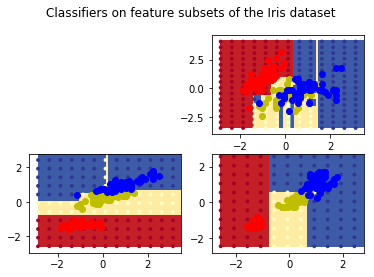

In [9]:
# plotting decision tree boundaries

import numpy as np
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.01  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 2

models = [DecisionTreeClassifier(max_depth=None)]
          
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print( model_details + " with features", pair, "has a score of", scores )

        plt.subplot(2, 2, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=cmap)

        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()

# Ensembling

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

Why are we learning about ensembling?

- Very popular method for improving the predictive performance of machine learning models
- Provides a foundation for understanding more sophisticated models

## Lesson objectives

Students will be able to:

- Define ensembling and its requirements
- Identify the two basic methods of ensembling
- Decide whether manual ensembling is a useful approach for a given problem
- Explain bagging and how it can be applied to decision trees
- Explain how out-of-bag error and feature importances are calculated from bagged trees
- Explain the difference between bagged trees and Random Forests
- Build and tune a Random Forest model in scikit-learn
- Decide whether a decision tree or a Random Forest is a better model for a given problem

# Part 1: Introduction

Let's pretend that instead of building a single model to solve a binary classification problem, you created **five independent models**, and each model was correct about 70% of the time. If you combined these models into an "ensemble" and used their majority vote as a prediction, how often would the ensemble be correct?

In [10]:
import numpy as np

# set a seed for reproducibility
np.random.seed(1234)

# generate 1000 random numbers (between 0 and 1) for each model, representing 1000 observations
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# print the first 20 predictions from each model
print preds1[:20]
print preds2[:20]
print preds3[:20]
print preds4[:20]
print preds5[:20]

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]
[1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1]
[1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0]
[0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1]


In [11]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)

# print the ensemble's first 20 predictions
print ensemble_preds[:20]

[1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1]


In [12]:
# how accurate was each individual model?
print preds1.mean()
print preds2.mean()
print preds3.mean()
print preds4.mean()
print preds5.mean()

0.713
0.665
0.717
0.712
0.687


In [13]:
# how accurate was the ensemble?
print ensemble_preds.mean()

0.841


**Note:** As you add more models to the voting process, the probability of error decreases, which is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

## What is ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

There are two basic **methods for ensembling:**

- Manually ensemble your individual models
- Use a model that ensembles for you

# Part 2: Manual ensembling

What makes a good manual ensemble?

- Different types of **models**
- Different combinations of **features**
- Different **tuning parameters**

![Machine learning flowchart](images/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*

## Comparing manual ensembling with a single model approach

**Advantages of manual ensembling:**

- Increases predictive accuracy
- Easy to get started

**Disadvantages of manual ensembling:**

- Decreases interpretability
- Takes longer to train
- Takes longer to predict
- More complex to automate and maintain
- Small gains in accuracy may not be worth the added complexity

# Part 3: Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement:

In [14]:
# set a seed for reproducibility
np.random.seed(1)

# create an array of 1 through 20
nums = np.arange(1, 21)
print nums

# sample that array 20 times with replacement
print np.random.choice(a=nums, size=20, replace=True)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**
    - Take a vote for **classification trees**

Notes:

- **Each bootstrap sample** should be the same size as the original training set.
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times an averaging the results.

## Manually implementing bagged decision trees (with B=10)

In [15]:
# read in and prepare the vehicle training data\n",
url = 'data/vehicles_train.csv'
train = pd.read_csv(url)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
train

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [16]:
# set a seed for reproducibility
np.random.seed(123)

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=14, size=14, replace=True) for _ in range(1, 11)]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [17]:
# show the rows for the first decision tree
train.iloc[samples[0], :]

,price,year,miles,doors,vtype
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


In [18]:
# read in and prepare the vehicle testing data
url = 'data/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [19]:
from sklearn.tree import DecisionTreeRegressor

# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# list for storing predicted price from each tree
predictions = []

# define testing data
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

# grow one tree for each bootstrap sample and make predictions on testing data
for sample in samples:
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

# convert predictions from list to NumPy array
predictions = np.array(predictions)
predictions

array([[  1300.,   5000.,  14000.],
       [  1300.,   1300.,  13000.],
       [  3000.,   3000.,  13000.],
       [  4000.,   5000.,  13000.],
       [  1300.,   5000.,  13000.],
       [  4000.,   5000.,  14000.],
       [  4000.,   4000.,  13000.],
       [  4000.,   5000.,  13000.],
       [  3000.,   5000.,   9500.],
       [  4000.,   5000.,   9000.]])

In [20]:
# average predictions
np.mean(predictions, axis=0)

array([  2990.,   4330.,  12450.])

In [21]:
# calculate RMSE
from sklearn import metrics
y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

998.58232843700307

## Bagged decision trees in scikit-learn (with B=500)

In [22]:
# define the training and testing sets
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [23]:
# instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1)

In [24]:
# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([  3344.2,   5395. ,  12902. ])

In [25]:
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

657.80003040437748

## Estimating out-of-sample error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

On average, each bagged tree uses about **two-thirds** of the observations. For each tree, the **remaining observations** are called "out-of-bag" observations.

In [26]:
# show the first bootstrap sample
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [27]:
# show the "in-bag" observations for each sample
for sample in samples:
    print set(sample)

set([0, 1, 2, 3, 6, 9, 10, 11, 12, 13])
set([0, 1, 2, 3, 4, 7, 9, 13])
set([0, 2, 3, 4, 6, 7, 8, 9, 12, 13])
set([0, 1, 2, 3, 5, 6, 8, 10, 11, 12])
set([2, 3, 4, 6, 10, 11, 12, 13])
set([0, 1, 4, 5, 6, 7, 9, 10, 11])
set([0, 1, 2, 3, 4, 5, 8, 9, 12])
set([1, 2, 3, 5, 6, 7, 9, 11])
set([1, 3, 6, 7, 8, 9, 11, 12])
set([0, 1, 3, 4, 5, 6, 8, 10, 11, 13])


In [28]:
# show the "out-of-bag" observations for each sample
for sample in samples:
    print sorted(set(range(14)) - set(sample))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


How to calculate **"out-of-bag error":**

1. For every observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [29]:
# compute the out-of-bag R-squared score (not MSE, unfortunately!) for B=500
bagreg.oob_score_

0.79869551339899825

## Estimating feature importance

Bagging increases **predictive accuracy**, but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** calculate the total amount that **MSE** is decreased due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** calculate the total amount that **Gini index** is decreased due to splits over a given feature, averaged over all trees

# Part 4: Random Forests

Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

# Building and tuning decision trees and Random Forests


## Preparing the data

In [30]:
# allow plots to appear in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# define X and y
feature_cols = ['inter_stroke_time', 'stroke_duration', 'start_x', 'start_y', 'stop_x', 'stop_y', 'direct_end_to_end', 'mean_resultant', 'udlr_flag', 'direction_end_to_end_line', 
                                          'twenty_v', 'fifty_v', 'eighty_v', 'twenty_a', 
                                               'fifty_a', 'eighty_a', 'largest_deviation', 'twenty_d', 'fifty_d', 'eighty_d',
                                              'average_direction', 'length_of_trajectory', 'length_of_trajectory',
                                              'ratio_end_to_end', 'average_velocity', 'median_acceleration', 'mid_stroke_pressure',
                                              'mid_stroke_area', 'mid_stroke_finger', 'change_finger', 'phone_orientation']
X = touch[feature_cols]
y = touch['user_id']

NameError: name 'touch' is not defined

## Predicting user_id with classification tree

Find the best **max_depth** for a decision tree using cross-validation:

In [34]:
# list of values to try for max_depth
max_depth_range = range(1, 31)

# list to store the average accuracy for each value of max_depth
accuracy_scores = []

# use 3-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(np.mean(cross_val_score(treeclf, X, y, cv=3, scoring='accuracy')))

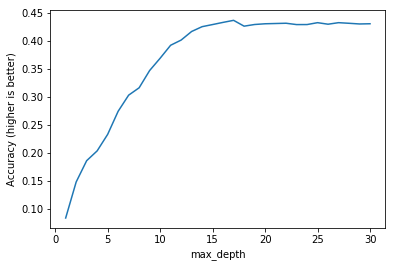

In [35]:
# plot max_depth (x-axis) versus Accuracy (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy (higher is better)')

In [36]:
# show the best Accuracy and the corresponding max_depth
sorted(zip(accuracy_scores, max_depth_range))[-1]

(0.43653818399782601, 17)

In [37]:
# max_depth=17 was best, so fit a tree using that parameter
treeclf = DecisionTreeClassifier(max_depth=17, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [38]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
26,mid_stroke_pressure,0.132662
9,direction_end_to_end_line,0.098229
2,start_x,0.082181
4,stop_x,0.075600
27,mid_stroke_area,0.069060
3,start_y,0.059783
5,stop_y,0.053477
6,direct_end_to_end,0.047422
24,average_velocity,0.041846
1,stroke_duration,0.035210


In [39]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()
rfclf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which is the number of trees that should be grown. It should be a large enough value that the error seems to have "stabilized".

In [40]:
# list of values to try for n_estimators
estimator_range = range(10, 300, 20)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    print estimator,
    rfclf = RandomForestClassifier(n_estimators=estimator, random_state=1)
    accuracy_scores.append(np.mean(cross_val_score(rfclf, X, y, cv=3, scoring='accuracy')))

10 30 50 70 90 110 130 150 170 190 210 230 250 270 290


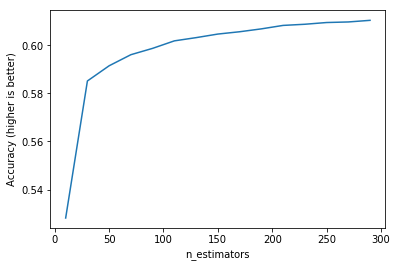

In [41]:
# plot n_estimators (x-axis) versus Accuracy (y-axis)
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy (higher is better)')

### Tuning max_features

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

In [47]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 5-fold cross-validation with each value of max_features (WARNING: SLOW!)
for features in feature_range:
    print features,
    rfclf = RandomForestClassifier(max_features=features, random_state=1)
    accuracy_scores.append(np.mean(cross_val_score(rfclf, X, y, cv=5, scoring='accuracy')))

 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31


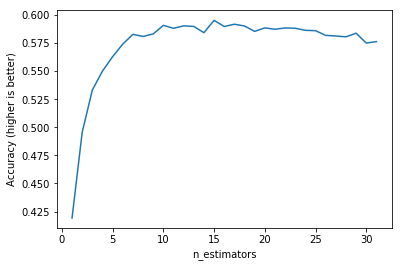

In [48]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy (higher is better)')

In [ ]:
# show the best RMSE and the corresponding max_features
sorted(zip(accuracy_scores, feature_range))[-1]

### Fitting a Random Forest with the best parameters

In [51]:
# max_features=8 is best and n_estimators=150 is sufficiently large
rfclf = RandomForestClassifier(n_estimators=150, max_features=8, oob_score=True, random_state=1)
rfclf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [53]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfclf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
26,mid_stroke_pressure,0.124116
2,start_x,0.066953
4,stop_x,0.060786
9,direction_end_to_end_line,0.060401
27,mid_stroke_area,0.057904
3,start_y,0.052351
5,stop_y,0.047091
6,direct_end_to_end,0.041190
24,average_velocity,0.037365
21,length_of_trajectory,0.036024


In [55]:
# compute the out-of-bag R-squared score
rfclf.oob_score_

0.78722179585571761

## Comparing Random Forests with decision trees

**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict

![Machine learning flowchart](images/driver_ensembling.png)

*Machine learning flowchart created by the [second place finisher](http://blog.kaggle.com/2015/04/20/axa-winners-interview-learning-telematic-fingerprints-from-gps-data/) of Kaggle's [Driver Telematics competition](https://www.kaggle.com/c/axa-driver-telematics-analysis)*

In [69]:
# Plotting the Decision Boundary of four types of trees:
#     1. decision trees
#     2. random forest
#     4. ExtraTreesClassifier(http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)
#     5. Adaboost (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)

('DecisionTree with features', [0, 1], 'has a score of', 0.92666666666666664)
('RandomForest with 30 estimators with features', [0, 1], 'has a score of', 0.92666666666666664)
('ExtraTrees with 30 estimators with features', [0, 1], 'has a score of', 0.92666666666666664)
('AdaBoost with 30 estimators with features', [0, 1], 'has a score of', 0.83999999999999997)
('DecisionTree with features', [0, 2], 'has a score of', 0.99333333333333329)
('RandomForest with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('ExtraTrees with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('AdaBoost with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('DecisionTree with features', [2, 3], 'has a score of', 0.99333333333333329)
('RandomForest with 30 estimators with features', [2, 3], 'has a score of', 0.99333333333333329)
('ExtraTrees with 30 estimators with features', [2, 3], 'has a score of', 0.99333333333333329)
('Ad

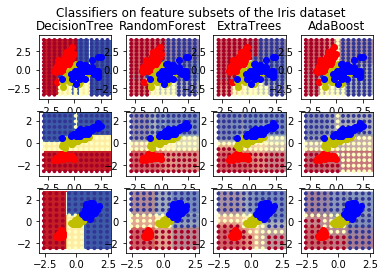

In [70]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print( model_details + " with features", pair, "has a score of", scores )

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=cmap)

        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()

In [71]:
# VotingClassifier is a manual ensembler
# It will take in several classifier models and have them duke it out
# You can either have them vote hard or soft
# A hard vote is like a ballot system, each model gets a set number of votes
# A soft vote includes models combing their predict_proba methods together


from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [72]:
# Breast Cancer Detection Dataset

In [73]:
breast_cancer = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None)
breast_cancer.columns = ['ID', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
breast_cancer.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [74]:
# They have ? where values are missing
breast_cancer[breast_cancer['Bare Nuclei']=='?'].head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2


In [75]:
breast_cancer.replace(to_replace='?', value=np.nan, inplace=True)
# replace ? with null values

breast_cancer.dropna(inplace=True)
# drop said null values

breast_cancer.isnull().sum()

ID                             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [76]:
breast_cancer.shape

(683, 11)

In [77]:
breast_cancer['Class'].value_counts(normalize=True)
# score to beat is 65%

2    0.650073
4    0.349927
Name: Class, dtype: float64

In [78]:
X = breast_cancer.drop(['ID', 'Class'], axis=1)
y = breast_cancer.Class

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

In [18]:
models = [('rf', RandomForestClassifier(n_estimators=10)),
          ('decision', DecisionTreeClassifier(max_depth=3))
         ] 
# try a few models by themselves
for index, model in models:
    print index, np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    print
# each one can beat the null accuracy by itself

rf 0.565005935402

decision 0.198163956047



In [19]:
vc1 = VotingClassifier(models, voting='hard')
np.mean(cross_val_score(vc1, X, y, cv=5, scoring='accuracy'))

0.41069052894241276

In [20]:
vc2 = VotingClassifier(models, voting='soft')
np.mean(cross_val_score(vc2, X, y, cv=5, scoring='accuracy'))
# Neither of these are better than a single random forest!

0.5632019688121892

In [21]:
vc3 = VotingClassifier(models, voting='soft', weights=[2, 1])
np.mean(cross_val_score(vc1, X, y, cv=5, scoring='accuracy'))

0.40890358404658905

In [27]:
from sklearn.model_selection import GridSearchCV
params = {'voting':['soft', 'hard'], 'weights':[[1, 1], [2, 1], [1, 2]], 'rf__n_estimators':range(10,50,10), 'decision__max_depth':[None, 1, 2]}

In [23]:
grid = GridSearchCV(vc3, params, cv=5, scoring='accuracy')

In [24]:
# WARNING SUPER SLOWWWWWWW
# WARNING SUPER SLOWWWWWWW
grid.fit(X, y)  # WARNING SUPER SLOWWWWWWW # WARNING SUPER SLOWWWWWWW # WARNING SUPER SLOWWWWWWW 
# WARNING SUPER SLOWWWWWWW
# WARNING SUPER SLOWWWWWWW

GridSearchCV(cv=5, error_score='raise',
       estimator=VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))],
         n_jobs=1, voting='soft', weights=[2, 1]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'voting': ['soft', 'hard'], 'weights': [[1, 1], [2, 1], [1, 2]], 'rf__n_estimators': [10, 20, 30, 40], 'decision__max_depth': [None, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [25]:
grid.best_score_

# Ah there it is

0.6303242517267843

In [26]:
grid.best_params_

{'decision__max_depth': 1,
 'rf__n_estimators': 40,
 'voting': 'hard',
 'weights': [2, 1]}

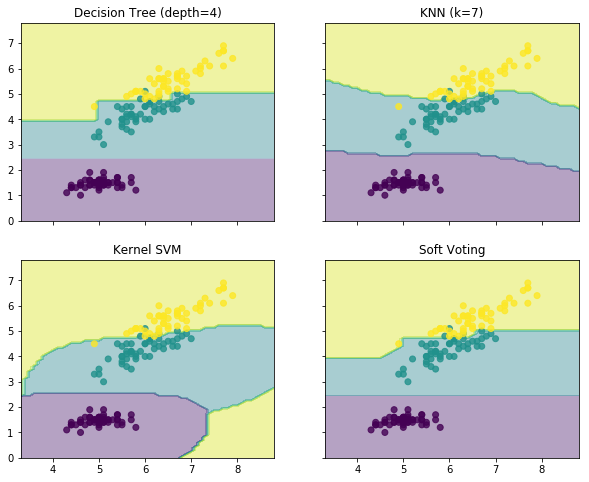

In [88]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Clustering

## Agenda:

1. K-means clustering
2. Clustering evaluation
3. DBSCAN clustering

In [92]:
# beer dataset
import pandas as pd
url = 'data/beer.txt'
beer = pd.read_csv(url, sep=' ')
beer

,name,calories,sodium,alcohol,cost
0,Budweiser,144,15,4.7,0.43
1,Schlitz,151,19,4.9,0.43
2,Lowenbrau,157,15,0.9,0.48
3,Kronenbourg,170,7,5.2,0.73
4,Heineken,152,11,5.0,0.77
5,Old_Milwaukee,145,23,4.6,0.28
6,Augsberger,175,24,5.5,0.40
7,Srohs_Bohemian_Style,149,27,4.7,0.42
8,Miller_Lite,99,10,4.3,0.43
9,Budweiser_Light,113,8,3.7,0.40


How would you cluster these beers?

In [93]:
# define X
X = beer.drop('name', axis=1)

What happened to y?

## Part 1: K-means clustering

In [94]:
# K-means with 3 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=1)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [95]:
# review the cluster labels
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1], dtype=int32)

In [103]:
# save the cluster labels and sort by cluster
beer['cluster'] = km.labels_
beer.sort_values('cluster')

,name,calories,sodium,alcohol,cost,cluster
0,Budweiser,144,15,4.7,0.43,0
1,Schlitz,151,19,4.9,0.43,0
2,Lowenbrau,157,15,0.9,0.48,0
3,Kronenbourg,170,7,5.2,0.73,0
4,Heineken,152,11,5.0,0.77,0
5,Old_Milwaukee,145,23,4.6,0.28,0
6,Augsberger,175,24,5.5,0.40,0
7,Srohs_Bohemian_Style,149,27,4.7,0.42,0
17,Heilemans_Old_Style,144,24,4.9,0.43,0
16,Hamms,139,19,4.4,0.43,0


What do the clusters seem to be based on? Why?

In [104]:
# review the cluster centers
km.cluster_centers_

array([[ 150.        ,   17.        ,    4.52142857,    0.52071429],
       [ 102.75      ,   10.        ,    4.075     ,    0.44      ],
       [  70.        ,   10.5       ,    2.6       ,    0.42      ]])

In [105]:
# calculate the mean of each feature for each cluster
beer.groupby('cluster').mean()

,calories,sodium,alcohol,cost
cluster,,,,
0,150.00,17.0,4.521429,0.520714
1,102.75,10.0,4.075000,0.440000
2,70.00,10.5,2.600000,0.420000


In [106]:
# save the DataFrame of cluster centers
centers = beer.groupby('cluster').mean()

In [107]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [108]:
# create a "colors" array for plotting
import numpy as np
colors = np.array(['red', 'green', 'blue', 'yellow'])

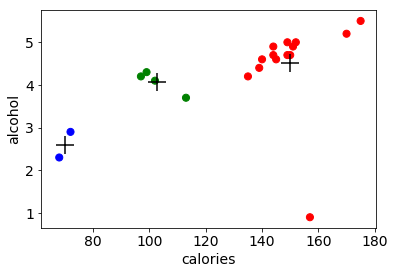

In [109]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(beer.calories, beer.alcohol, c=colors[list(beer.cluster)], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.calories, centers.alcohol, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('calories')
plt.ylabel('alcohol')

/Users/sinanozdemir/Desktop/blackhat-vegas-ml/bh-env/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1442c9e90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1477b72d0>]], dtype=object)

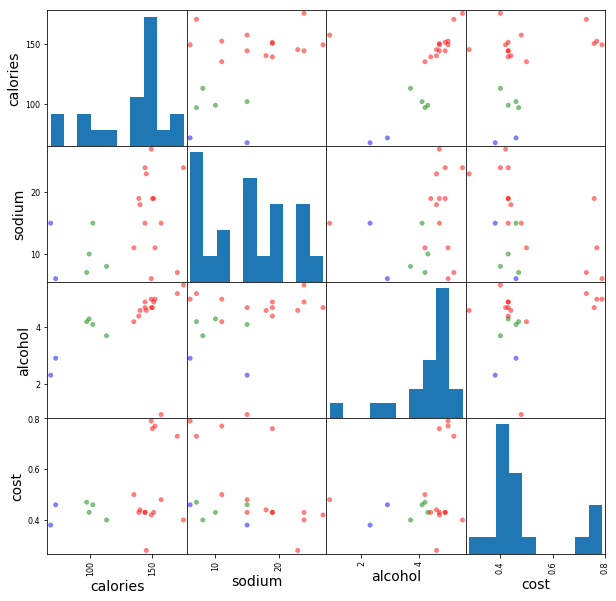

In [110]:
# scatter plot matrix (0=red, 1=green, 2=blue)
pd.scatter_matrix(X, c=colors[list(beer.cluster)], figsize=(10,10), s=100)

### Repeat with scaled data

In [111]:
# center and scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [112]:
# K-means with 3 clusters on scaled data
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [113]:
# save the cluster labels and sort by cluster
beer['cluster'] = km.labels_
beer.sort('cluster')

AttributeError: 'DataFrame' object has no attribute 'sort'

What are the "characteristics" of each cluster?

In [114]:
# review the cluster centers
beer.groupby('cluster').mean()

,calories,sodium,alcohol,cost
cluster,,,,
0,148.375,21.125,4.7875,0.4075
1,105.375,10.875,3.3250,0.4475
2,155.250,10.750,4.9750,0.7625


/Users/sinanozdemir/Desktop/blackhat-vegas-ml/bh-env/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x147bb83d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x148217b10>]], dtype=object)

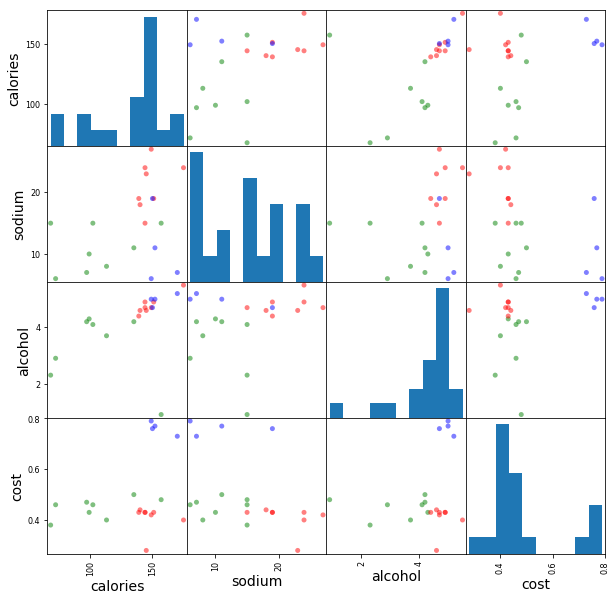

In [115]:
# scatter plot matrix of new cluster assignments (0=red, 1=green, 2=blue)
pd.scatter_matrix(X, c=colors[list(beer.cluster)], figsize=(10,10), s=100)

Do you notice any cluster assignments that seem a bit odd? How might we explain those?

## Part 2: Clustering evaluation

The [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) is a common metric for evaluating clustering "performance" in situations when the "true" cluster assignments are not known.

A Silhouette Coefficient is calculated for **each observation**:

$$SC = \frac{b-a} {max(a, b)}$$

- a = mean distance to all other points in **its cluster**
- b = mean distance to all other points in **the next nearest cluster**

It ranges from -1 (worst) to 1 (best). A **global score** is calculated by taking the mean score for all observations.

In [116]:
# calculate SC for K=3
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

0.4577741591090948

In [117]:
# calculate SC for K=2 through K=19
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

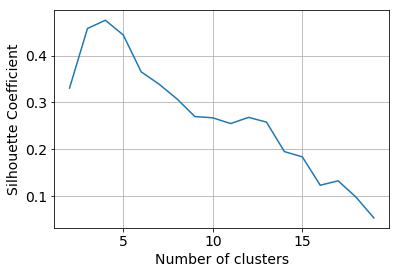

In [118]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [119]:
# K-means with 4 clusters on scaled data
km = KMeans(n_clusters=4, random_state=1)
km.fit(X_scaled)
beer['cluster'] = km.labels_
beer.sort('cluster')

AttributeError: 'DataFrame' object has no attribute 'sort'

## Part 3: DBSCAN clustering

In [120]:
# DBSCAN with eps=1 and min_samples=3
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1, min_samples=3)
db.fit(X_scaled)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    min_samples=3, n_jobs=1, p=None)

In [121]:
# review the cluster labels
db.labels_

array([ 0,  0, -1,  1,  1, -1, -1,  0,  2,  2,  0,  2,  0, -1,  1, -1,  0,
        0, -1,  2])

In [126]:
# save the cluster labels and sort by cluster
beer['cluster'] = db.labels_
beer.sort_values('cluster')

,name,calories,sodium,alcohol,cost,cluster
2,Lowenbrau,157,15,0.9,0.48,-1
5,Old_Milwaukee,145,23,4.6,0.28,-1
6,Augsberger,175,24,5.5,0.40,-1
18,Olympia_Goled_Light,72,6,2.9,0.46,-1
13,Becks,150,19,4.7,0.76,-1
15,Pabst_Extra_Light,68,15,2.3,0.38,-1
0,Budweiser,144,15,4.7,0.43,0
1,Schlitz,151,19,4.9,0.43,0
7,Srohs_Bohemian_Style,149,27,4.7,0.42,0
17,Heilemans_Old_Style,144,24,4.9,0.43,0


In [127]:
# review the cluster centers
beer.groupby('cluster').mean()

,calories,sodium,alcohol,cost
cluster,,,,
-1,127.833333,17.0,3.483333,0.460000
0,143.142857,19.0,4.628571,0.440000
1,157.000000,8.0,5.066667,0.763333
2,102.750000,10.0,4.075000,0.440000


/Users/sinanozdemir/Desktop/blackhat-vegas-ml/bh-env/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1490555d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1498ff910>]], dtype=object)

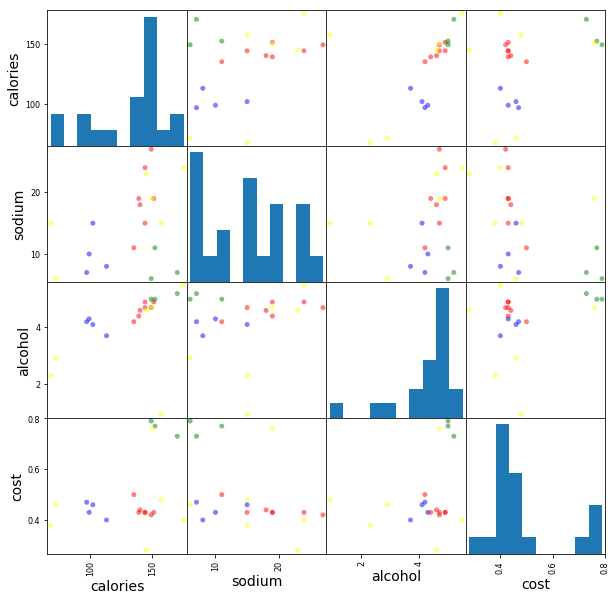

In [128]:
# scatter plot matrix of DBSCAN cluster assignments (0=red, 1=green, 2=blue, -1=yellow)
pd.scatter_matrix(X, c=colors[list(beer.cluster)], figsize=(10,10), s=100)

In [129]:
# Silhousette Coefficient also works on DBSCAN
metrics.silhouette_score(X_scaled, db.labels_)

0.23754067391520689

In [130]:
# calculate SC for K=2 through K=19
eps_range = range(1, 10)
scores = []
for k in eps_range:
    db = DBSCAN(eps=k, min_samples=3)
    db.fit(X_scaled)
    if len(set(db.labels_)) > 1:
        scores.append(metrics.silhouette_score(X_scaled, db.labels_))
    else:
        scores.append(0)

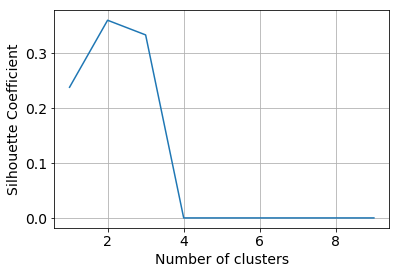

In [131]:
# plot the results
plt.plot(eps_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [133]:
#  topic modelling for news

In [134]:
from sklearn.datasets import fetch_20newsgroups
# adapted in http://alexperrier.github.io/jekyll/update/2015/09/16/segmentation_twitter_timelines_lda_vs_lsa.html

In [135]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# grab only four topics of articles
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

No handlers could be found for logger "sklearn.datasets.twenty_newsgroups"


In [136]:
dataset.data[0]

u'From: healta@saturn.wwc.edu (Tammy R Healy)\nSubject: Re: who are we to judge, Bobby?\nLines: 38\nOrganization: Walla Walla College\nLines: 38\n\nIn article <1993Apr14.213356.22176@ultb.isc.rit.edu> snm6394@ultb.isc.rit.edu (S.N. Mozumder ) writes:\n>From: snm6394@ultb.isc.rit.edu (S.N. Mozumder )\n>Subject: Re: who are we to judge, Bobby?\n>Date: Wed, 14 Apr 1993 21:33:56 GMT\n>In article <healta.56.734556346@saturn.wwc.edu> healta@saturn.wwc.edu (TAMMY R HEALY) writes:\n>>Bobby,\n>>\n>>I would like to take the liberty to quote from a Christian writer named \n>>Ellen G. White.  I hope that what she said will help you to edit your \n>>remarks in this group in the future.\n>>\n>>"Do not set yourself as a standard.  Do not make your opinions, your views \n>>of duty, your interpretations of scripture, a criterion for others and in \n>>your heart condemn them if they do not come up to your ideal."\n>>                         Thoughts Fromthe Mount of Blessing p. 124\n>>\n>>I hope quoting

In [137]:
labels = dataset.target  # actual targets

In [138]:
labels[0]

0

In [139]:
dataset.target_names  # target names, the above text is about atheism

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [140]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
# use a normalizer module to normalize data for KMeans which is affected by scale

vect = TfidfVectorizer(stop_words='english')  # vectorize the data
normal = Normalizer(copy=False)               # normalize the vectorized data
km = KMeans(n_clusters=4, random_state=1)     # cluster

feature_preprocessing = Pipeline(steps=(('vect', vect), ('normal', normal)))
pipe = Pipeline(steps=(('preprocess', feature_preprocessing), ('cluster', km)))

In [141]:
pipe.fit(dataset.data)

Pipeline(steps=(('preprocess', Pipeline(steps=(('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', pre...rs=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0))))

In [142]:
predicted_topics = pipe.steps[1][1].labels_

In [143]:
predicted_topics

array([2, 0, 0, ..., 0, 0, 0], dtype=int32)

In [144]:
[dataset.target_names[p] for p in labels][:5]  # the kmeans labels as words

['alt.atheism',
 'comp.graphics',
 'comp.graphics',
 'talk.religion.misc',
 'comp.graphics']

In [145]:
df = pd.DataFrame({'text':dataset.data, 'cluster':predicted_topics, 'actual': [dataset.target_names[p] for p in labels]})

In [146]:
# Make a readable dataframe

df.head()

,actual,cluster,text
0,alt.atheism,2,From: healta@saturn.wwc.edu (Tammy R Healy)\nS...
1,comp.graphics,0,From: jk87377@lehtori.cc.tut.fi (Kouhia Juhana...
2,comp.graphics,0,Subject: PHIGS User Group Conference\nFrom: ha...
3,talk.religion.misc,2,From: joslin@pogo.isp.pitt.edu (David Joslin)\...
4,comp.graphics,0,From: adaptive@cs.nps.navy.mil (zyda res acct)...


In [147]:
from sklearn.feature_extraction.text import CountVectorizer
smaller_tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
for cluster in range(4):
    print cluster, df[df.cluster==cluster].actual.value_counts()
    matrix = smaller_tfidf.fit_transform(df[df.cluster==cluster].text)
    freqs = [(word, matrix.getcol(idx).sum()) for word, idx in smaller_tfidf.vocabulary_.items()]
    #sort from largest to smallest
    print [k for k in sorted (freqs, key = lambda x: -x[1])[:10]]
    print
    print

0 sci.space             981
comp.graphics         967
talk.religion.misc     98
alt.atheism            39
Name: actual, dtype: int64
[(u'edu', 151.60931659605916), (u'com', 90.351407898806414), (u'space', 80.34779349883334), (u'subject', 70.384248982600838), (u'lines', 69.816258666126714), (u'organization', 68.683407324526684), (u'university', 60.706055612895867), (u'writes', 57.330407385173345), (u'posting', 56.363668196473938), (u'host', 54.348561144333011)]


1 talk.religion.misc    70
alt.atheism           37
Name: actual, dtype: int64
[(u'sandvik', 11.493184744306847), (u'com', 8.4194395112546587), (u'kent', 7.2687834960860602), (u'apple', 6.9149944738576314), (u'edu', 6.078429458367995), (u'newton', 5.8113837266689785), (u'god', 5.0984586698095962), (u'jesus', 4.2475709317767532), (u'article', 4.0865421128808137), (u'people', 3.9007828500661419)]


2 alt.atheism           588
talk.religion.misc    448
sci.space               6
comp.graphics           6
Name: actual, dtype: int64


In [148]:
# output the Silhouette score, oof

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(feature_preprocessing.fit_transform(dataset.data), pipe.steps[1][1].labels_))

Silhouette Coefficient: 0.006


In [ ]:
# LSA -- Latent Semantic Analysis

# LSA is a vector-based dimension reduction technique 
# that allows to project a large feature space to a smaller one

# It is a tfidf vectorizer that is then put through an svd and finally normalized
# before being put through a kmeans clustering

In [150]:
%%time

vect = TfidfVectorizer(stop_words='english')
lsa = make_pipeline(vect, Normalizer(copy=False))

X_tfidfd = lsa.fit_transform(dataset.data)

km = KMeans(n_clusters=4, random_state=1)

print("Clustering sparse data with %s" % km)
km.fit(X_tfidfd)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_tfidfd, km.labels_))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)
Silhouette Coefficient: 0.006
CPU times: user 1min 4s, sys: 564 ms, total: 1min 5s
Wall time: 1min 6s


In [151]:
from sklearn.decomposition import TruncatedSVD
# we will be using SVD as our dimension reduction technique and a normalizer to normalize data (for KMeans)

In [152]:
vect = TfidfVectorizer(stop_words='english')
svd = TruncatedSVD(n_components=5)
lsa = make_pipeline(vect, svd, Normalizer(copy=False))

X_lsa = lsa.fit_transform(dataset.data)

In [153]:
X_lsa.shape  # fewer columns

(3387, 5)

In [154]:
%%time
km = KMeans(n_clusters=4, random_state=1)

print("Clustering sparse data with %s" % km)
km.fit(X_lsa)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_lsa, km.labels_))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)
Silhouette Coefficient: 0.384
CPU times: user 361 ms, sys: 110 ms, total: 471 ms
Wall time: 457 ms


In [155]:
km.labels_

array([3, 2, 2, ..., 1, 2, 2], dtype=int32)

In [156]:
labels

array([0, 1, 1, ..., 2, 1, 1])

In [157]:
# try a bunch of components, look at the scores below

for n_components in (5, 10, 25, 50, 100):
    vect = TfidfVectorizer(stop_words='english')
    svd = TruncatedSVD(n_components=n_components)
    lsa = make_pipeline(vect, svd, Normalizer(copy=False))

    X_lsa = lsa.fit_transform(dataset.data)
    km = KMeans(n_clusters=4, random_state=1)

    print("Clustering sparse data with %s components" % n_components)
    km.fit(X_lsa)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X_lsa, km.labels_))

Clustering sparse data with 5 components
Silhouette Coefficient: 0.403
Clustering sparse data with 10 components
Silhouette Coefficient: 0.287
Clustering sparse data with 25 components
Silhouette Coefficient: 0.130
Clustering sparse data with 50 components
Silhouette Coefficient: 0.065
Clustering sparse data with 100 components
Silhouette Coefficient: 0.044


In [158]:
dataset.data[0]

u'From: healta@saturn.wwc.edu (Tammy R Healy)\nSubject: Re: who are we to judge, Bobby?\nLines: 38\nOrganization: Walla Walla College\nLines: 38\n\nIn article <1993Apr14.213356.22176@ultb.isc.rit.edu> snm6394@ultb.isc.rit.edu (S.N. Mozumder ) writes:\n>From: snm6394@ultb.isc.rit.edu (S.N. Mozumder )\n>Subject: Re: who are we to judge, Bobby?\n>Date: Wed, 14 Apr 1993 21:33:56 GMT\n>In article <healta.56.734556346@saturn.wwc.edu> healta@saturn.wwc.edu (TAMMY R HEALY) writes:\n>>Bobby,\n>>\n>>I would like to take the liberty to quote from a Christian writer named \n>>Ellen G. White.  I hope that what she said will help you to edit your \n>>remarks in this group in the future.\n>>\n>>"Do not set yourself as a standard.  Do not make your opinions, your views \n>>of duty, your interpretations of scripture, a criterion for others and in \n>>your heart condemn them if they do not come up to your ideal."\n>>                         Thoughts Fromthe Mount of Blessing p. 124\n>>\n>>I hope quoting

### Gradient Descent

In [159]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

In machine learning, we are familiar with the concept of error and we are generally concerned with minimizing said error by modelling error as a function and defining the optimal model that has the lowest error

Recall in linear regression, we were conerned with minimising the sum of squared residuals. In Calculus, to find the optimal point of a function, we must utilize the **derivative**.

In vector (multi-dimensional) calculus, we generalize the concept of the derivative as the gradient.

The gradient is the derivative of a single function of all of its variables. We use the gradient in roder to create a **directional derivative**. The directional derivative gives us both a direction and magnitute of "how steep" the function is at that point and facing that direction. Our goal is follow the directional derivatives to find the minimum (or maximum) value of a function.

Imagine a three-dimensional error function for linear regression

<img src="images/error.png">

On a cross section, we are attempting to find the bottom of that function given a starting point

<img src="images/2d-grad.gif">

In a 3-d plot:

<img src="images/3d-grad.png">



<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ and learning rate $\alpha$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>end for</b>




As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [160]:
# define a function f
f = lambda x: x**3-2*x**2+2

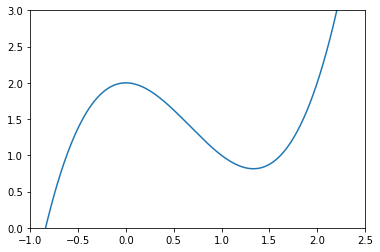

In [161]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

We can see from plot above that our local minimum is gonna be near around 1.4 or 1.5 (on the x-axis), but let's pretend that we don't know that, so we set our starting point (arbitrarily, in this case) at $x_0 = 2$

In [162]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
learning_rate = 0.1 # step size
precision = 0.0001  # stopping criterions

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_prime(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
    x_old = x_new
    gradient = f_prime(x_old)
    x_new = x_old + (learning_rate * -gradient)
    x_list.append(x_new)
    y_list.append(f(x_new))
print "Local minimum occurs at:", x_new
print "Number of steps:", len(x_list)

Local minimum occurs at: 1.33342535085
Number of steps: 17


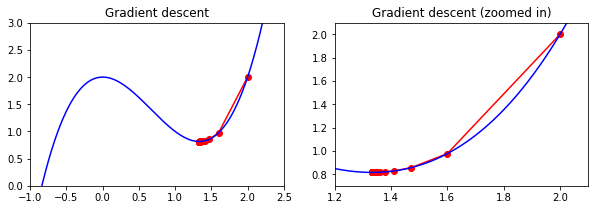

In [163]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([1.2,2.1])
plt.ylim([.7,2.1])
plt.title("Gradient descent (zoomed in)")
plt.show()

Why do we follow the negative gradient (negative derivatives?) Because to calculate the directional derivative we must do:

Directional Derivative of function f($D_u(f)$) = $\nabla f.u$ where u is the unit vector in the direction we care about.

|| indicates **magnitute** which is the length of the vector. The magnitute of the directional derivative gives us the rate of change of movement in that direction.

We also know that $\nabla f.u = |\nabla(f)|$* $|u|$*$cos(\theta)$ where $\theta$ is the angle between the two vectors.

because $u$ is a unit vector, it has length one, so we are left with

$D_u(f) = |\nabla(f)|cos(\theta)$

The maximum value of this directional derivative ccours when the $cos(\theta) = 1$ when $\theta=0$ therefore when the vector u is the same direction as $\nabla f$

The maximum value of $D_u(f)$ (and hence then the maximum rate of change of the function  ) is therefore given by $|D_u(f)|$  and will occur in the direction given by $\nabla f(x)$.

In [164]:
# Let's take a look at a real example

In [165]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_regression

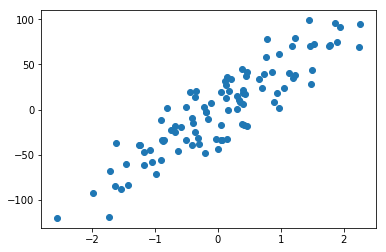

In [166]:
# Make a dataset that can be fit fairly well with linear regression
X, y = make_regression( n_samples=100, n_features=1, random_state=0, noise=20) 
plt.scatter(X, y)

Our goal is to find the equation of the straight line $h_\theta(x) = \theta_0 + \theta_1 x$ that best fits our data points. The function that we are trying to minimize in this case is the sum of squared residuals:

$J(\theta_0,\theta_1) = \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)^2$

In this case, our gradient will be defined in two dimensions:

$\frac{\partial}{\partial \theta_0} J(\theta_0,\theta_1) = 2  \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)$

$\frac{\partial}{\partial \theta_1} J(\theta_0,\theta_1) = 2  \sum\limits_{i=1}^m ((h_\theta(x_i)-y_i) \cdot x_i)$

In [167]:
# a function to make the y coordinate from the x, m, and b variables
def computeYCoordinate(b, m, x_point):
    return b + (np.dot(m, x_point))

In [168]:
computeYCoordinate(2, 1, 4)  # 6 = 1(4) + 2

6

In [169]:
# y = mx + b
# m is slope, b is y-intercept
# given b and m, calculate the average squared error between the line and the data
def computeErrorForLineGivenPoints(b, m):
    totalError = 0
    for i in range(0, len(X)):
        totalError += (y[i] - computeYCoordinate(b, m, X[i])) ** 2
    return totalError

In [170]:
computeErrorForLineGivenPoints(1, 1)  # sum of squared residuals for the line y = 1*x + 1

array([ 223612.85471532])

In [171]:
# OK, heres the real s**t

# this function computes a single iteration of gradient descent
# for a given b and m value and a learning_rate, it will calculate the gradient of the the sum of squared residuals
# and then change the b and m values by adding the negative of the gradient (which is the fastest descent of the function)

def stepGradient(b_current, m_current, learningRate):
    b_gradient = 0  # start b and m gradient at 0
    m_gradient = 0
    N = float(len(X))
    for i in range(0, len(X)):    
        # this is creating the b_gradient and m_gradient values
        b_gradient += 2 * (computeYCoordinate(b_current, m_current, X[i]) - y[i])
        m_gradient += 2 * X[i] * (computeYCoordinate(b_current, m_current, X[i]) - y[i])
    new_b = b_current + (learningRate * -b_gradient)  # add the negative of the gradient times the learning rate
    new_m = m_current + (learningRate * -m_gradient)
    return [new_b, new_m]

In [172]:
# Why a learning rate?

# Because if we take steps too large, then we might miss the minimum!

In [173]:
x_old = 0
x_new = 2 # The algorithm starts at x=2


learning_rate = .45 # step size IS NOW .45
max_steps = 10  # setting a max number of steps its allowed to take

precision = 0.0001  # stopping criterions

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_prime(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision and max_steps > 0:
    max_steps -= 1
    x_old = x_new
    gradient = f_prime(x_old)
    x_new = x_old + (learning_rate * -gradient)
    x_list.append(x_new)
    y_list.append(f(x_new))
print "Local minimum occurs at:", x_new
print "Number of steps:", len(x_list)

Local minimum occurs at: 1.3632337343
Number of steps: 11


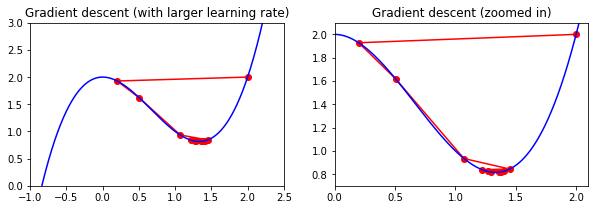

In [174]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent (with larger learning rate)")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([0,2.1])
plt.ylim([.7,2.1])
plt.title("Gradient descent (zoomed in)")
plt.show()

In [175]:
x_old = 0
x_new = 2 # The algorithm starts at x=2


learning_rate = .5 # step size IS NOW .5
max_steps = 10  # setting a max number of steps its allowed to take

precision = 0.0001  # stopping criterions

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_prime(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision and max_steps > 0:
    max_steps -= 1
    x_old = x_new
    gradient = f_prime(x_old)
    x_new = x_old + (learning_rate * -gradient)
    x_list.append(x_new)
    y_list.append(f(x_new))
print "Local minimum occurs at:", x_new
print "Number of steps:", len(x_list)

Local minimum occurs at: 0.0
Number of steps: 3


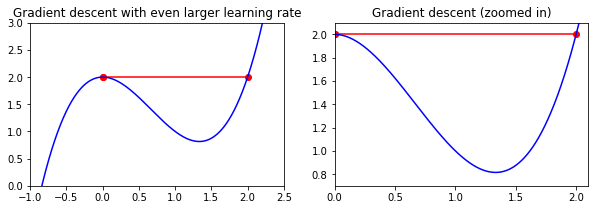

In [176]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent with even larger learning rate")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([0,2.1])
plt.ylim([.7,2.1])
plt.title("Gradient descent (zoomed in)")
plt.show()

0 0 [ 232303.37018662] original error


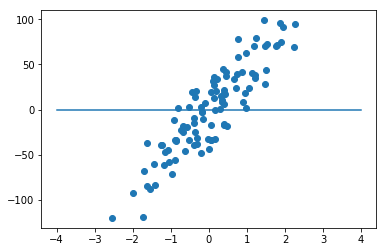

step 1 [ 0.1869221] [ 8.71749533] [ 164043.62049684]


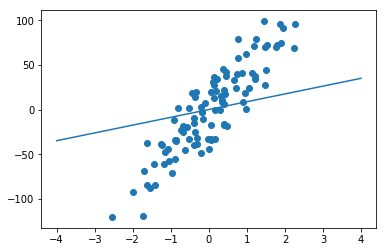

step 2 [ 0.23218456] [ 15.65542552] [ 120817.54424213]


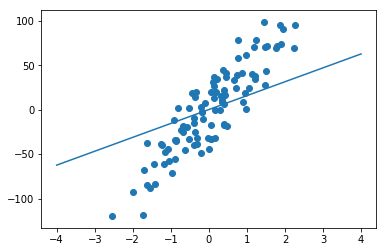

step 20 [-1.46586746] [ 42.37972975] [ 45693.18179626]


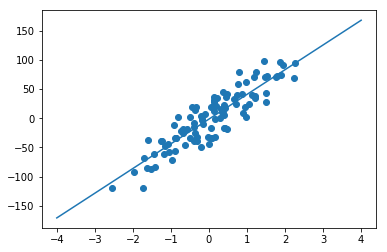

step 40 [-1.62483261] [ 42.8476391] [ 45668.59880405]


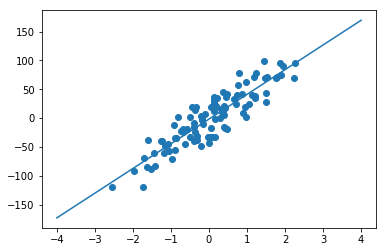

(array([-1.62778447]), array([ 42.85255258]))

In [177]:
old_b, old_m = 0, 0 # starting values for b and m
print old_b, old_m, computeErrorForLineGivenPoints(old_b, old_m), "original error"

plt.plot([-4,4], [old_m * -4 + old_b,old_m * 4 + old_b])
plt.scatter(X, y)
plt.show()

scores = []
for step in range(1,50): 
    new_b, new_m = stepGradient(old_b, old_m, .001)
    if step % 20  == 0 or step < 3: 
        print "step", step, new_b, new_m, computeErrorForLineGivenPoints(new_b, new_m)
        plt.plot([-4,4], [new_m * -4 + new_b,new_m * 4 + new_b])
        plt.scatter(X, y)
        plt.show()
    scores.append(computeErrorForLineGivenPoints(new_b, new_m))
    old_b, old_m = new_b, new_m
new_b, new_m

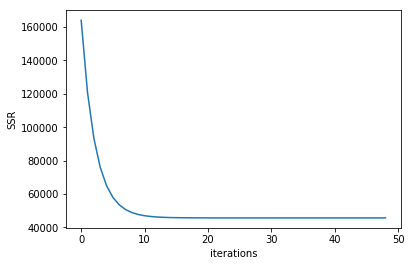

In [178]:
# plot change in SSR over iterations
iterations = np.arange(len(scores))
plt.plot(iterations,scores)
plt.xlabel("iterations")
plt.ylabel("SSR")
plt.show()

In [179]:
new_b, new_m

(array([-1.62778447]), array([ 42.85255258]))

In [180]:
from sklearn.linear_model import LinearRegression  # use sklearn linear regression

In [181]:
# sklearn coefficients
linreg = LinearRegression()
linreg.fit(X, y)
linreg.intercept_, linreg.coef_

/Users/sinanozdemir/Desktop/blackhat-vegas-ml/bh-env/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


(-1.6283636540614514, array([ 42.85335573]))

In [182]:
# This is called "Batch" gradient descent because the parameters are updated

Notice that in the method above we need to calculate the gradient in every step of our algorithm. In our example , this is not a big deal since there are only a hundred data points. But imagine that we had 2 million data points. If this were the case, it would certainly make the method above far less efficient.

In machine learning, the algorithm above is often called <b>batch gradient descent</b> to contrast it with <b>mini-batch gradient descent</b> (which we will not go into here) and <b>stochastic gradient descent</b>.

As we said above, in batch gradient descent, we must look at every example in the entire training set on every step (in cases where a training set is used for gradient descent). This can be quite slow if the training set is sufficiently large. In <b>stochastic gradient descent</b>, we update our values after looking at <i>each</i> item in the training set, so that we can start making progress right away. Recall the linear regression example above. In that example, we calculated the gradient for each of the two theta values as follows:

$\frac{\partial}{\partial \theta_0} J(\theta_0,\theta_1) = 2  \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)$

$\frac{\partial}{\partial \theta_1} J(\theta_0,\theta_1) = 2  \sum\limits_{i=1}^m ((h_\theta(x_i)-y_i) \cdot x_i)$

Where $h_\theta(x) = \theta_0 + \theta_1 x$

Then we followed this algorithm (where $\alpha$ was a non-adapting stepsize):

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>end for</b>

When the sample data had a hundred data points as in the example above, calculating the gradient was not very costly. But for very large data sets, this would not be the case. So instead, we consider a stochastic gradient descent algorithm for simple linear regression such as the following, where m is the size of the data set:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Randomly shuffle the data set <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>for</b> i = 1 to m <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\begin{bmatrix}
 \theta_{1} \\ 
 \theta_2 \\ 
 \end{bmatrix}=\begin{bmatrix}
 \theta_1 \\ 
 \theta_2 \\ 
 \end{bmatrix}-\alpha\begin{bmatrix}
 2(h_\theta(x_i)-y_i) \\ 
 2x_i(h_\theta(x_i)-y_i) \\ 
 \end{bmatrix}$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>end for</b> <br> 
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

Typically, with stochastic gradient descent, you will run through the entire data set 1 to 10 times (see value for k in line 2 of the pseudocode above), depending on how fast the data is converging and how large the data set is.

With batch gradient descent, we must go through the entire data set before we make any progress. With this algorithm though, we can make progress right away and continue to make progress as we go through the data set. Therefore, stochastic gradient descent is often preferred when dealing with large data sets.

Unlike gradient descent, stochastic gradient descent will tend to oscillate <i>near</i> a minimum value rather than continuously getting closer. It may never actually converge to the minimum though. One way around this is to slowly decrease the step size $\alpha$ as the algorithm runs. However, this is less common than using a fixed $\alpha$.

In [183]:
# Same example, with stochastic

# this function computes a single iteration of gradient descent
# for a given b and m value and a learning_rate, it will calculate the gradient of the the sum of squared residuals
# and then change the b and m values by adding the negative of the gradient (which is the fastest descent of the function)

def stochasticGradient(b_current, m_current, learningRate):
    N = float(len(X))
    for i in range(0, len(X)):    
        # this is creating the b_gradient and m_gradient values
        b_gradient = 2 * (computeYCoordinate(b_current, m_current, X[i]) - y[i])
        m_gradient = 2 * X[i] * (computeYCoordinate(b_current, m_current, X[i]) - y[i])
        b_current += (learningRate * -b_gradient)  # add the negative of the gradient times the learning rate
        m_current += (learningRate * -m_gradient)
    return b_current, m_current

0 0 [ 232303.37018662] original error


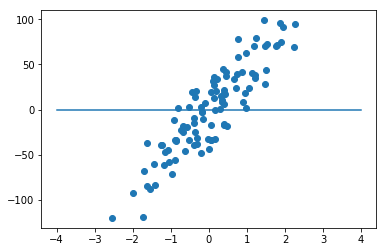

step 1 [ 0.10889323] [ 7.87005966] [ 170001.20983312]


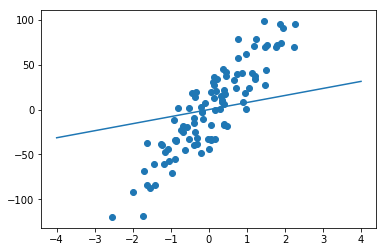

step 2 [ 0.12004391] [ 14.28314429] [ 128586.30892575]


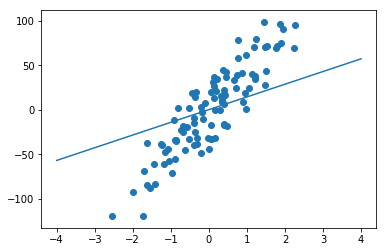

step 20 [-1.51264704] [ 41.89262257] [ 45762.69548476]


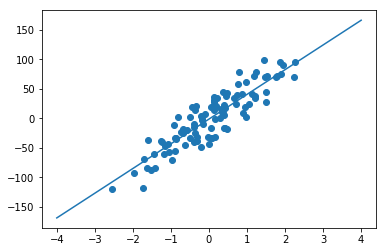

step 40 [-1.71967929] [ 42.61921471] [ 45675.27264594]


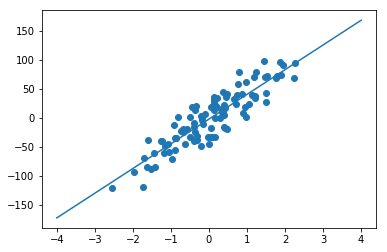

(array([-1.72541229]), array([ 42.63054079]))

In [184]:
old_b, old_m = 0, 0 # starting values for b and m
print old_b, old_m, computeErrorForLineGivenPoints(old_b, old_m), "original error"

plt.plot([-4,4], [old_m * -4 + old_b,old_m * 4 + old_b])
plt.scatter(X, y)
plt.show()

scores = []
for step in range(1,50): 
    new_b, new_m = stochasticGradient(old_b, old_m, .001)
    if step % 20  == 0 or step < 3: 
        print "step", step, new_b, new_m, computeErrorForLineGivenPoints(new_b, new_m)
        plt.plot([-4,4], [new_m * -4 + new_b,new_m * 4 + new_b])
        plt.scatter(X, y)
        plt.show()
    scores.append(computeErrorForLineGivenPoints(new_b, new_m))
    old_b, old_m = new_b, new_m
new_b, new_m

In [185]:
# Note the m and b are SLIGHTLY different than with batch
# (array([-1.62778447]), array([ 42.85255258]))
# stochastic results are not always the actual minimum because of the noise in the error

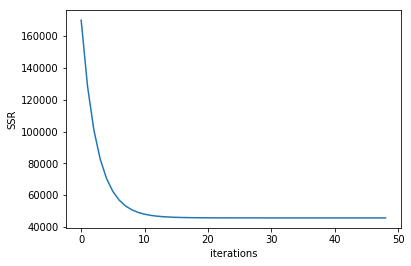

In [186]:
# plot change in SSR over iterations in sotchastic gradient descent
iterations = np.arange(len(scores))
plt.plot(iterations,scores)
plt.xlabel("iterations")
plt.ylabel("SSR")
plt.show()

In [187]:
# Not a huge difference, why?

Let's look at another example where we illustrate the use of stochastic gradient descent for linear regression. In the example below, we'll create a set of 500,000 points around the line $y = 2x+17+\epsilon$, for values of x between 0 and 100:

In [188]:
# function that makes line with noise
# m = 17
# b = 2
f = lambda x: x*2+17+np.random.randn(len(x))*10

large_X = np.random.random(500000)*100
large_y = f(large_X)
m = len(large_y)

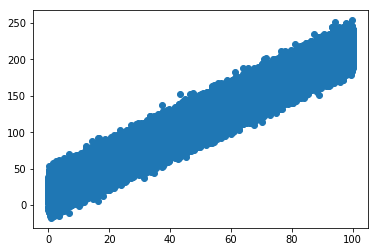

In [189]:
plt.scatter(large_X, large_y)

First, let's randomly shuffle around our dataset. Note that in this example, this step isn't strictly necessary since the data is already in a random order. However, that obviously may not always be the case:

In [190]:
from random import shuffle

x_shuf = []
y_shuf = []
index_shuf = range(len(large_X))
shuffle(index_shuf)
for i in index_shuf:
    x_shuf.append(large_X[i])
    y_shuf.append(large_y[i])

In [191]:
h = lambda theta_0,theta_1,x: theta_0 + theta_1*x
cost = lambda theta_0,theta_1, x_i, y_i: (h(theta_0,theta_1,x_i)-y_i)**2  # get squared residual of a single example

In [192]:
theta_old = np.array([0.,0.])
theta_new = np.array([1.,1.]) # The algorithm starts at [1,1] meaning m = 1 and b = 1
# note here that theta0 is b and theta1 is m
n_k = 0.00001 # step size

iter_num = 0
s_k = np.array([float("inf"),float("inf")])
sum_cost = 0
cost_list = []

for j in range(10):
    for i in range(m):
        iter_num += 1
        theta_old = theta_new
        # update parameters for EACH training example
        s_k[0] = (h(theta_old[0],theta_old[1],large_X[i])-large_y[i])
        s_k[1] = (h(theta_old[0],theta_old[1],large_X[i])-large_y[i])*large_X[i]
        s_k = (-1)*s_k  # negative gradient
        theta_new = theta_old + n_k * s_k # add negative gradient times learning rate to parameters
        sum_cost += cost(theta_old[0],theta_old[1],large_X[i],large_y[i]) # calculate SUM of squared residuls
        if (i+1) % 10000 == 0:  # every so often, add cost to to list of costs
            cost_list.append(sum_cost)
            sum_cost = 0   
            
print "Local minimum occurs where:"
print "theta_0(m) =", theta_new[0] 
print "theta_1(b) =", theta_new[1]

Local minimum occurs where:
theta_0(m) = 16.9882592921
theta_1(b) = 2.01117292542


As you can see, our values for $\theta_0$ and $\theta_1$ are close to their true values of 17 and 2.

Now, we plot our cost versus the number of iterations. As you can see, the cost goes down quickly at first, but starts to level off as we go through more iterations:

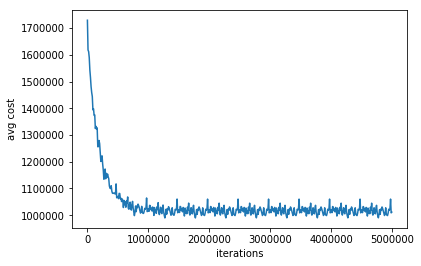

In [193]:
# notice the noise in out cost deduction
iterations = np.arange(len(cost_list))*10000
plt.plot(iterations,cost_list)
plt.xlabel("iterations")
plt.ylabel("avg cost")
plt.show()

In [194]:
# scikit-learn has its own stocastic gradient descent modules
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
from sklearn.linear_model import SGDRegressor, SGDClassifier

clf = SGDRegressor(loss='squared_loss', n_iter=200)
# squared loss is sum of squared residuals minimization
# so what model minimizes su of squared residuals?
clf.fit(X, y)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=200, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [195]:
clf.intercept_, clf.coef_

(array([-1.62441931]), array([ 42.84000905]))

In [196]:
large_X = np.array(large_X).reshape(500000,1)
large_y = np.array(large_y).reshape(500000,1)

In [197]:
clf = SGDRegressor(loss='squared_loss', n_iter=200)

clf.fit(large_X, large_y)
clf.intercept_, clf.coef_

/Users/sinanozdemir/Desktop/blackhat-vegas-ml/bh-env/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([ 16.8830027]), array([ 1.84256974]))

In [198]:
iris = datasets.load_iris()
iris_X = iris["data"]
iris_Y = iris["target"]

numFolds = 10
kf = KFold(len(iris_X), numFolds, shuffle=True)

In [199]:
# These are "Class objects". For each Class, find the AUC through
# 10 fold cross validation.

In [200]:
Models = [LogisticRegression, SGDClassifier]
params = [{}, {"loss": "log", 'n_iter':1000}]

for param, Model in zip(params, Models):
    total = 0
    for train_indices, test_indices in kf:
        train_X = iris_X[train_indices, :]; train_Y = iris_Y[train_indices]
        test_X = iris_X[test_indices, :]; test_Y = iris_Y[test_indices]
        reg = Model(**param)
        reg.fit(train_X, train_Y)
        predictions = reg.predict(test_X)
        total += accuracy_score(test_Y, predictions)

    accuracy = total / numFolds
    print "Accuracy score of {0}: {1}".format(Model.__name__, accuracy)

# Accuracy score of LogisticRegression: 0.95333
# Accuracy score of SGDClassifier: 0.94

Accuracy score of LogisticRegression: 0.953333333333
Accuracy score of SGDClassifier: 0.953333333333


In [201]:
# run it again, note the score changes, because of the shuffling of the data in each time we
# fit a SGD model

Models = [LogisticRegression, SGDClassifier]
params = [{}, {"loss": "log", 'n_iter':1000}]

for param, Model in zip(params, Models):
    total = 0
    for train_indices, test_indices in kf:
        train_X = iris_X[train_indices, :]; train_Y = iris_Y[train_indices]
        test_X = iris_X[test_indices, :]; test_Y = iris_Y[test_indices]
        reg = Model(**param)
        reg.fit(train_X, train_Y)
        predictions = reg.predict(test_X)
        total += accuracy_score(test_Y, predictions)

    accuracy = total / numFolds
    print "Accuracy score of {0}: {1}".format(Model.__name__, accuracy)

# Accuracy score of LogisticRegression: 0.96
# Accuracy score of SGDClassifier: 0.96

Accuracy score of LogisticRegression: 0.953333333333
Accuracy score of SGDClassifier: 0.966666666667


In [202]:
from sklearn.grid_search import GridSearchCV

In [203]:
# many parameters to optimize over, WARNING SLOW
iris = datasets.load_iris()
sgd = SGDClassifier()
parameters = {'loss':("hinge", "log", "modified_huber", "squared_hinge", "perceptron"), 
              'penalty':('none', 'l2', 'l1', 'elasticnet'),
              'alpha': (1e-4,1e-3,1e-2,1e-1,1,1e1),
              'n_iter': (100, 1000, 10000)
             }
clf = GridSearchCV(sgd, parameters, scoring='accuracy')
clf.fit(iris.data, iris.target)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('none', 'l2', 'l1', 'elasticnet'), 'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'), 'n_iter': (100, 1000, 10000), 'alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10.0)},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [204]:
clf.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=100,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

In [205]:
clf.best_score_

0.9866666666666667

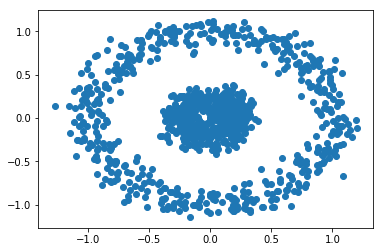

In [206]:
# MORE DATA

# Logistic Regression is a high bias low variance model that is also non-parametric

from sklearn.datasets import make_circles
from sklearn.cross_validation import cross_val_score
circles_X, circles_y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(circles_X[:,0], circles_X[:,1])

In [207]:
# many parameters to optimize over for circles, WARNING VERY SLOW
sgd = SGDClassifier()
parameters = {'loss':("hinge", "log", "modified_huber", "squared_hinge", "perceptron"), 
              'penalty':('none', 'l2', 'l1', 'elasticnet'),
              'alpha': (1e-4,1e-3,1e-2,1e-1,1,1e1),
              'n_iter': (100, 1000, 10000)
             }
clf = GridSearchCV(sgd, parameters, scoring='accuracy')
clf.fit(circles_X, circles_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('none', 'l2', 'l1', 'elasticnet'), 'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'), 'n_iter': (100, 1000, 10000), 'alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10.0)},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [208]:
print clf.best_estimator_
print
print clf.best_score_, "accuracy"

SGDClassifier(alpha=10.0, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_hinge', n_iter=100, n_jobs=1,
       penalty='none', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

0.678 accuracy


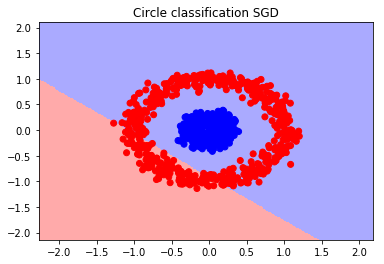

In [209]:
# SGD implements model that have a linear decision boundary. It is no different than logistic regression and linear
# regression at its simplest

# Run this cell several times to see the model fit itself widly differently each time!

from matplotlib.colors import ListedColormap
import numpy as np

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# we create an instance of Neighbours Classifier and fit the data.
best_model = clf.best_estimator_
best_model.fit(circles_X, circles_y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = circles_X[:, 0].min() - 1, circles_X[:, 0].max() + 1
y_min, y_max = circles_X[:, 1].min() - 1, circles_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(circles_X[:, 0], circles_X[:, 1], c=circles_y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Circle classification SGD")

plt.show()

**To summarize, from sklearn...**

Stochastic Gradient Descent is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features.

The advantages of Stochastic Gradient Descent are:
* Efficiency.
* Ease of implementation (lots of opportunities for code tuning).

The disadvantages of Stochastic Gradient Descent include:
* SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
* SGD is sensitive to feature scaling.
